In [1]:
#import files
import json
import zstandard as zstd
import tldextract
import numpy as np
import pandas as pd
import scipy.sparse
import shutil
import pickle
import time
from scipy.sparse import csr_matrix,coo_matrix
from pandas.api.types import CategoricalDtype
import random
from scipy.sparse.linalg import spsolve
import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.metrics import ndcg_score
os.environ['MKL_NUM_THREADS'] = '1' #To avoid multithreading.
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
#function to save large files
#change to protocol 0 for text output
def save_obj(obj, file_path_name):
    with open(file_path_name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(file_path_name):
    with open(file_path_name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Required Domain list

In [3]:
news_domain_df = pd.read_csv("/research/cbuntain/projects/recsys.trajectories/datafiles/fb_domain_ideology.csv", sep=",")
# shows top 10 rows
#print(news_domain_df.head(5))
news_domain_list = news_domain_df['domain'].tolist()

## Decompress Twitter files

In [4]:
# Here twitter 2020-04 files are decompressed in 3 lots. Each lot has 240 .gz files. They are stored in .../datafiles/2020-04_twitter/
#command example:
# Lot1
# cp statuses.log.2020-04-0[1-9]* /research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot1/
# cp statuses.log.2020-04-10-* /research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot1/


# Lot2
# cp statuses.log.2020-04-1[1-9]* /research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot2/
# cp statuses.log.2020-04-20-* /research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot2/


# Lot3
# cp statuses.log.2020-04-2[1-9]* /research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot3/
# cp statuses.log.2020-04-30-* /research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot3/
# Lot1: 2020-04-01 to 2020-04-10
# Lot2: 2020-04-11 to 2020-04-20
# Lot3: 2020-04-21 to 2020-04-30

# This function uses glob to select multiple .gz files together to get decompressed.

def decompress_multiple_gz_to_folder(input_file_path, output_file):
    print('Decompressing gz files')
    with open(output_file, 'wb') as f_out:
        for fname in glob(input_file_path):
            start_time = time.perf_counter()
            with gzip.open(fname, 'rb') as f_in:
                f_out.writelines(f_in)
    print('complete')
    print('time: ' , time.perf_counter()-start_time)       

In [9]:
file_path = "/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/"

In [15]:
#lot1- 2020-04-01* to 2020-04-10*

decompress_multiple_gz_to_folder("/research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot1/*gz",
                                "/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/decompressed_twitter_lot1.txt")


Extracting files
complete
time:  7.4822979755699635


In [20]:
#lot2- 2020-04-11* to 2020-04-20*

decompress_multiple_gz_to_folder("/research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot2/*gz",
                                "/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/decompressed_twitter_lot2.txt")


Extracting files
complete
time:  8.601083085872233


In [5]:
#lot3- 2020-04-21* to 2020-04-30*

decompress_multiple_gz_to_folder("/research/cbuntain/projects/recsys.trajectories/datafiles/202004_twitter/Lot3/*gz",
                                "/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/decompressed_twitter_lot3.txt")


Decompressing gz files
complete
time:  6.551221293862909


In [6]:
#Testing decompress file
f = open('/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/decompressed_twitter_lot3.txt', 'r')
for i in range(1):
    print(f.readline())

{"in_reply_to_status_id_str":null,"in_reply_to_status_id":null,"created_at":"Mon Apr 20 23:59:56 +0000 2020","in_reply_to_user_id_str":null,"source":"<a href=\"https://mobile.twitter.com\" rel=\"nofollow\">Twitter Web App<\/a>","retweet_count":0,"retweeted":false,"geo":null,"filter_level":"low","in_reply_to_screen_name":null,"is_quote_status":false,"id_str":"1252386551104827394","in_reply_to_user_id":null,"favorite_count":0,"id":1252386551104827394,"text":"COMO É QUE EU POSSO VOMITAR BATATA SE EU COMI REPOLHO","place":null,"lang":"pt","quote_count":0,"favorited":false,"coordinates":null,"truncated":false,"timestamp_ms":"1587427196657","reply_count":0,"entities":{"urls":[],"hashtags":[],"user_mentions":[],"symbols":[]},"contributors":null,"user":{"utc_offset":null,"friends_count":155,"profile_image_url_https":"https://pbs.twimg.com/profile_images/1250493281684934665/dK3RoEBo_normal.jpg","listed_count":5,"profile_background_image_url":"http://abs.twimg.com/images/themes/theme1/bg.png","d

## Build relations file

In [7]:
#this function helps in extracting user with their respective shared domains

def build_relations_file(read_file, write_file):
    with open(write_file, 'w') as f:
        with open(read_file, 'rb') as fh:
            print('trying to read file')
            #iterates each line
            print('looping')
            start_time = time.perf_counter()
            num_unshortened_urls = 0
            for line in fh:
                try:
                    object = json.loads(line)
                    urls_in_tweet = object['entities']['urls']
                    #remove indices
                    for e in urls_in_tweet:
                        e.pop('indices', None)
                    
                    if len(object['entities']["urls"])>0:
                        for key, value in urls_in_tweet[0].items():
                            domains = tldextract.extract(value).registered_domain.lower()
                            if domains in news_domain_list:
                                num_unshortened_urls += 1
                                f.write( domains + " " + object['user']['screen_name'] + '\n')
                except Exception as e:
                        print('read/loop error: ')
                        print(e)
    print('complete')
    print('time: ' , time.perf_counter()-start_time)
    print('unshortened ', num_unshortened_urls, ' urls')

In [17]:
#lot1- 2020-04-01* to 2020-04-10*

build_relations_file(file_path+"decompressed_twitter_lot1.txt",file_path+"relations_twitter_lot1.txt")


trying to read file
looping
complete
time:  7212.16423040349
unshortened  6690888  urls


In [22]:
#lot2- 2020-04-11* to 2020-04-20*

build_relations_file(file_path+"decompressed_twitter_lot2.txt",file_path+"relations_twitter_lot2.txt")


trying to read file
looping
complete
time:  5639.5730485878885
unshortened  6580122  urls


In [10]:
#lot3- 2020-04-21* to 2020-04-30*

build_relations_file(file_path+"decompressed_twitter_lot3.txt",file_path+"relations_twitter_lot3.txt")


trying to read file
looping
complete
time:  4809.659521274269
unshortened  6709794  urls


In [11]:
#Testing relations file
f = open('/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/relations_twitter_lot3.txt', 'r')
for i in range(5):
    print(f.readline())

twitter.com NbintAk

twitter.com NbintAk

twitter.com CarGoLa18

twitter.com CarGoLa18

twitter.com aurorareal



## Join all relations file

In [5]:
file_path = "/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/"

In [12]:
#Length of all relations file
file_path = "/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/"
def file_line_count(read_file):
    with open(read_file, 'r') as f:
        i = 0
        for i, l in enumerate(f):
            pass
        return i+1;
print("file line count: ")

file_line_count(file_path + "relations_twitter_lot1.txt")

file line count: 


6690888

In [13]:
file_line_count(file_path + "relations_twitter_lot2.txt")

6580122

In [14]:
file_line_count(file_path + "relations_twitter_lot3.txt")

6709794

In [15]:
#Join all the files

filenames = [file_path + 'relations_twitter_lot1.txt', 
             file_path + 'relations_twitter_lot2.txt',
             file_path + 'relations_twitter_lot3.txt']
with open(file_path + "relations_twitter_clubbed.txt", 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [16]:
file_line_count(file_path + "relations_twitter_clubbed.txt")

19980804

## Building User-Domain Matrix

In [6]:
#Make twitter data dataframe from clubbed relations file
colnames=['Domain','Username']
twitter_df = pd.read_csv(file_path + 'relations_twitter_clubbed.txt', sep=" ",names = colnames)

In [7]:
print(len(twitter_df))
print(twitter_df.head(5))

19980804
        Domain         Username
0    msnbc.com     sagetwitting
1    msnbc.com     sagetwitting
2  twitter.com    mylittlefaith
3  twitter.com    mylittlefaith
4  twitter.com  ThakurPrasadSa8


### Some basic check on reddit dataframe

In [8]:
twitter_df["domain_check"] = twitter_df['Domain'].isin(news_domain_list)
twitter_df.head(5)

,Domain,Username,domain_check
0,msnbc.com,sagetwitting,True
1,msnbc.com,sagetwitting,True
2,twitter.com,mylittlefaith,True
3,twitter.com,mylittlefaith,True
4,twitter.com,ThakurPrasadSa8,True


In [18]:
twitter_df.tail(20)

,Domain,Username,domain_check
19980784,twitter.com,abey_yaar_,True
19980785,twitter.com,abey_yaar_,True
19980786,twitter.com,MarioBone,True
19980787,twitter.com,MarioBone,True
19980788,twitter.com,aio_hfc,True
19980789,twitter.com,aio_hfc,True
19980790,twitter.com,leigh_fall,True
19980791,twitter.com,leigh_fall,True
19980792,twitter.com,mariian_suarez,True
19980793,twitter.com,mariian_suarez,True


In [9]:
#This proves only required domains are used
twitter_df.domain_check.value_counts()

True    19980804
Name: domain_check, dtype: int64

In [10]:
#twitter_df = twitter_df.drop_duplicates()
twitter_df.drop(columns=['domain_check'])
print(len(twitter_df))

19980804


In [11]:
print('Domain count:',len(twitter_df['Domain'].unique().tolist()))
print('Users count:',len(twitter_df['Username'].unique().tolist()))

Domain count: 1793
Users count: 6158059


In [12]:
#save and load twitter dataframe original
save_obj(twitter_df,"/research/cbuntain/projects/recsys.trajectories/datafiles/Twitter dataframes/twitter_df")



In [8]:
twitter_df = load_obj("/research/cbuntain/projects/recsys.trajectories/datafiles/Twitter dataframes/twitter_df")

In [9]:
len(twitter_df)

19980804

In [11]:
#counts no of domains shared by each user
twitter_count_df = twitter_df.groupby(["Username", "Domain"]).size().reset_index(name="Value")
print(twitter_count_df.head(5))

          Username       Domain  Value
0  0000000000007jb  twitter.com      2
1  000000000001029  twitter.com      4
2   000000000deniz  twitter.com      2
3      00000000yen  twitter.com      2
4      00000007Bts  twitter.com      4


In [19]:
twitter_count_df.tail(10)

,Username,Domain,Value
6506697,zzzzzzz68637331,twitter.com,6
6506698,zzzzzzz87663347,twitter.com,2
6506699,zzzzzzzjjs,twitter.com,2
6506700,zzzzzzzsannille,twitter.com,2
6506701,zzzzzzzssa,twitter.com,2
6506702,zzzzzzzsssszz,twitter.com,2
6506703,zzzzzzzzja,spotify.com,2
6506704,zzzzzzzztov,twitter.com,2
6506705,zzzzzzzzzezz,twitter.com,2
6506706,zzzzzzzzzz78,twitter.com,4


In [ ]:
#check memory of dataframe

print(twitter_count_df.memory_usage(deep=True)) 

BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")
    
print_memory_usage_of_data_frame(twitter_count_df)

In [7]:
print('Domain count:',len(twitter_count_df['Domain'].unique().tolist()))
print('Users count:',len(twitter_count_df['Username'].unique().tolist()))

Domain count: 1793
Users count: 6158058


In [ ]:
#save and load twitter count dataframe
save_obj(twitter_count_df,"/research/cbuntain/projects/recsys.trajectories/datafiles/Twitter dataframes/twitter_count_df")


In [10]:
twitter_count_df = load_obj("/research/cbuntain/projects/recsys.trajectories/datafiles/Twitter dataframes/twitter_count_df")
         

In [11]:
len(twitter_count_df)

6506707

## Create sparse matrix and dataframe

In [12]:
def create_sparse_matrix_dataframe(df):
    Username_c = CategoricalDtype(sorted(df.Username.unique()), ordered=True)
    Domain_c = CategoricalDtype(sorted(df.Domain.unique()), ordered=True)
    row = df.Username.astype(Username_c).cat.codes
    col = df.Domain.astype(Domain_c).cat.codes
    sparse_matrix = csr_matrix((df["Value"], (row, col)), \
                           shape=(Username_c.categories.size, Domain_c.categories.size))
    sdf = pd.DataFrame.sparse.from_spmatrix(sparse_matrix,index=Username_c.categories,
                         columns=Domain_c.categories,)
    return sparse_matrix, sdf

In [13]:
#sdf-->sparse dataframe
sparse_matrix , sdf = create_sparse_matrix_dataframe(twitter_count_df)

In [14]:
sparse_matrix

<6158058x1793 sparse matrix of type '<class 'numpy.longlong'>'
	with 6506707 stored elements in Compressed Sparse Row format>

In [15]:
sdf

,100percentfedup.com,1011now.com,10best.com,10news.com,10tv.com,11alive.com,12news.com,12newsnow.com,12up.com,13abc.com,...,yottagames.com,youngliving.com,yourcentralvalley.com,yourdailybible.com,youredm.com,yousign.org,youtube.com,zerohedge.com,zimbio.com,zinnedproject.org
0000000000007jb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000000001029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000000deniz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000000yen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000007Bts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzzzzzzsssszz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zzzzzzzzja,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zzzzzzzztov,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zzzzzzzzzezz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#drop twitter columns from the data 
list_of_cols_to_drop = ['twitter.com']
sdf_drop = sdf.drop(list_of_cols_to_drop, axis=1)
#sdf_drop is sparse dataframe with no twitter.com

In [17]:
sdf_drop.shape

(6158058, 1792)

In [11]:
#calculate sparsity function

def sparcity_value(df):
    matrix_size = df.shape[0]*df.shape[1] # Number of possible interactions in the matrix
    num_domains = len(df.nonzero()[0]) # Number of domains interacted with
    sparsity = 100*(1 - (num_domains/matrix_size))
    print("Sparsity of Matrix :" + str(sparsity))
    
sparcity_value(sparse_matrix) 

Sparsity of Matrix :99.9410698989065


## Filtering the sparse dataframe with no of links shared by each user

In [18]:
#count total link shared by each user
shared_links_count  = twitter_count_df.groupby('Username')['Value'].agg("sum")
shared_links_count

Username
0000000000007jb    2
000000000001029    4
000000000deniz     2
00000000yen        2
00000007Bts        4
                  ..
zzzzzzzsssszz      2
zzzzzzzzja         2
zzzzzzzztov        2
zzzzzzzzzezz       2
zzzzzzzzzz78       4
Name: Value, Length: 6158058, dtype: int64

In [23]:
#filter the sdf(sparse dataframe) by no of links shared 
#sdf_k : k represents no of links shared more than k

sdf_1 = sdf.loc[shared_links_count[shared_links_count > 1].index,:] #only to check decrease no of users
sdf_5 = sdf.loc[shared_links_count[shared_links_count > 5].index,:]
sdf_10 = sdf.loc[shared_links_count[shared_links_count > 10].index,:]
sdf_15 = sdf.loc[shared_links_count[shared_links_count > 15].index,:]
sdf_20 = sdf.loc[shared_links_count[shared_links_count > 20].index,:]
sdf_25 = sdf.loc[shared_links_count[shared_links_count > 25].index,:]

In [19]:
# sdf_drop_1 = sdf_drop.loc[shared_links_count[shared_links_count > 1].index,:] #only to check decrease no of users
# sdf_drop_5 = sdf_drop.loc[shared_links_count[shared_links_count > 5].index,:]
# sdf_drop_10 = sdf_drop.loc[shared_links_count[shared_links_count > 10].index,:]
# sdf_drop_15 = sdf_drop.loc[shared_links_count[shared_links_count > 15].index,:]
sdf_drop_20 = sdf_drop.loc[shared_links_count[shared_links_count > 20].index,:]
sdf_drop_25 = sdf_drop.loc[shared_links_count[shared_links_count > 25].index,:]

In [ ]:
print("Shape of more than 1 link shared User-Domain dataframe : ",sdf_1.shape)
print("Shape of more than 5 links shared User-Domain dataframe : ",sdf_5.shape)
print("Shape of more than 10 links shared User-Domain dataframe : ",sdf_10.shape)
print("Shape of more than 15 links shared User-Domain dataframe : ",sdf_15.shape)
print("Shape of more than 20 links shared User-Domain dataframe : ",sdf_20.shape)
print("Shape of more than 25 links shared User-Domain dataframe : ",sdf_25.shape)

In [15]:
print("Shape of more than 1 link shared User-Domain dataframe : ",sdf_drop_1.shape)
print("Shape of more than 5 links shared User-Domain dataframe : ",sdf_drop_5.shape)
print("Shape of more than 10 links shared User-Domain dataframe : ",sdf_drop_10.shape)
print("Shape of more than 15 links shared User-Domain dataframe : ",sdf_drop_15.shape)
print("Shape of more than 20 links shared User-Domain dataframe : ",sdf_drop_20.shape)
print("Shape of more than 25 links shared User-Domain dataframe : ",sdf_drop_25.shape)

Shape of more than 1 link shared User-Domain dataframe :  (6158058, 1792)
Shape of more than 5 links shared User-Domain dataframe :  (698242, 1792)
Shape of more than 10 links shared User-Domain dataframe :  (160641, 1792)
Shape of more than 15 links shared User-Domain dataframe :  (83469, 1792)
Shape of more than 20 links shared User-Domain dataframe :  (39100, 1792)
Shape of more than 25 links shared User-Domain dataframe :  (26017, 1792)


### Convert different sdf(sparse dataframes) into sparse matrices sp

In [16]:
# Sparse matrix creation for filtered sparse dataframe

sp5 = scipy.sparse.csr_matrix(sdf_drop_5.values)
sp10 = scipy.sparse.csr_matrix(sdf_drop_10.values)
sp15 = scipy.sparse.csr_matrix(sdf_drop_15.values)
sp20 = scipy.sparse.csr_matrix(sdf_drop_20.values)
sp25 = scipy.sparse.csr_matrix(sdf_drop_25.values)

In [ ]:
file= "/research/cbuntain/projects/recsys.trajectories/datafiles/Twitter dataframes/"

#the saved sparse matrices are the ones which donot have twitter.com as a domain

#save sparse matrix
scipy.sparse.save_npz(file+"sp5.npz", sp5, compressed=False)
scipy.sparse.save_npz(file+"sp10.npz", sp10, compressed=False)
scipy.sparse.save_npz(file+"sp15.npz", sp15, compressed=False)
scipy.sparse.save_npz(file+"sp20.npz", sp20, compressed=False)
scipy.sparse.save_npz(file+"sp25.npz", sp25, compressed=False)


In [5]:
#loads sparse matrix
# sp5 = scipy.sparse.load_npz(file+"sp5.npz")
# sp10 = scipy.sparse.load_npz(file+"sp10.npz")
# sp15 = scipy.sparse.load_npz(file+"sp15.npz")
sp20 = scipy.sparse.load_npz(file+"sp20.npz")
sp25 = scipy.sparse.load_npz(file+"sp25.npz")

In [19]:
#check sparcity

print("sparcity values")

print("Sparcity for sp5")
sparcity_value(sp5)
print("Sparcity for sp10")
sparcity_value(sp10)
print("Sparcity for sp15")
sparcity_value(sp15)
print("Sparcity for sp20")
sparcity_value(sp20)
print("Sparcity for sp25")
sparcity_value(sp25)

sparcity values
Sparcity for sp5
Sparsity of Matrix :99.97954389061078
Sparcity for sp10
Sparsity of Matrix :99.96215427012496
Sparcity for sp15
Sparsity of Matrix :99.9517624592877
Sparcity for sp20
Sparsity of Matrix :99.9384333896602
Sparcity for sp25
Sparsity of Matrix :99.93097318923341


## Code to implement recommendation system

### Split data into train/test

In [ ]:
'''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''

In [6]:
def make_train(ratings, pct_test):
   
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user ro

In [7]:
#split train/test data for different sp sparse matrix
#masking percentage = 20%

# train_sp5, test_sp5, item_users_altered_sp5 = make_train(sp5, pct_test = 0.2)
# train_sp10, test_sp10, item_users_altered_sp10 = make_train(sp10, pct_test = 0.2)
# train_sp15, test_sp15, item_users_altered_sp15 = make_train(sp15, pct_test = 0.2)
train_sp20, test_sp20, item_users_altered_sp20 = make_train(sp20, pct_test = 0.2)
train_sp25, test_sp25, item_users_altered_sp25 = make_train(sp25, pct_test = 0.2)

### Fit ALS model

In [8]:
#this function runs als model 

def train_model(train_dataset):
    alpha=15
    domain_user_data = (train_dataset*alpha).astype('double')
    model = implicit.als.AlternatingLeastSquares(factors=20, regularization = 0.1, iterations = 50)
    model.fit(domain_user_data.T)
    user_vecs = model.user_factors
    item_vecs = model.item_factors
    return domain_user_data,model,user_vecs,item_vecs

In [131]:
# domain_user_data_sp5, model_sp5, user_vecs_sp5, item_vecs_sp5  = train_model(train_sp5)
# domain_user_data_sp10, model_sp10, user_vecs_sp10, item_vecs_sp10  = train_model(train_sp10)
# domain_user_data_sp15, model_sp15, user_vecs_sp15, item_vecs_sp15  = train_model(train_sp15)
domain_user_data_sp20, model_sp20, user_vecs_sp20, item_vecs_sp20  = train_model(train_sp20)
domain_user_data_sp25, model_sp25, user_vecs_sp25, item_vecs_sp25  = train_model(train_sp25)

## Evaluation Metrics

In [24]:
def auc_score(predictions, test):
   
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [25]:
def calc_auc_ndcg(training_set, altered_users, predictions, test_set):
    
    start_time = time.perf_counter()
    
    # create empty lists to store AUC/NDCG for each user that had an item removed from the training set and popularity auc/ndcg
    store_auc,popularity_auc,store_ndcg1,store_ndcg2,store_ndcg3,store_ndcg5,store_ndcg10,popularity_ndcg = ([] for i in range(8))
    
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        #auc calculation
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and domain
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
        
        #ndcg calculation
        store_ndcg1.append(ndcg_score([actual],[pred],k = 1)) # Calculate NDCG@1 for the given user and domain
        store_ndcg2.append(ndcg_score([actual],[pred],k = 2)) # Calculate NDCG@2 for the given user and domain
        store_ndcg3.append(ndcg_score([actual],[pred],k = 3)) # Calculate NDCG@3 for the given user and domain
        store_ndcg5.append(ndcg_score([actual],[pred],k = 5)) # Calculate NDCG@4 for the given user and domain
        store_ndcg10.append(ndcg_score([actual],[pred],k = 10)) # Calculate NDCG@10 for the given user and domain
        popularity_ndcg.append(ndcg_score([actual],[pop],k = 10)) # Calculate NDCG@10 using most popular domains
        
    # End users iteration
   
    print('time: ' , time.perf_counter()-start_time)
    
    return float('%.3f'%np.mean(store_auc)),float('%.3f'%np.mean(popularity_auc)),float('%.3f'%np.mean(store_ndcg1)),float('%.3f'%np.mean(store_ndcg2)),float('%.3f'%np.mean(store_ndcg3)),float('%.3f'%np.mean(store_ndcg5)),float('%.3f'%np.mean(store_ndcg10)),float('%.3f'%np.mean(popularity_ndcg))
   
 # Return the mean AUC/NDCG rounded to three decimal places for both test and popularity benchmark

In [126]:
print("AUC/NDCG for sp5 model")
scores_sp5=calc_auc_ndcg(train_sp5, 
              item_users_altered_sp5, 
              [scipy.sparse.csr_matrix(user_vecs_sp5), scipy.sparse.csr_matrix(item_vecs_sp5.T)], 
              test_sp5)
print(scores_sp5)

print("AUC/NDCG for sp10 model")
scores_sp10=calc_auc_ndcg(train_sp10, 
              item_users_altered_sp10, 
              [scipy.sparse.csr_matrix(user_vecs_sp10), scipy.sparse.csr_matrix(item_vecs_sp10.T)], 
              test_sp10)
print(scores_sp10)

print("AUC/NDCG for sp15 model")
scores_sp15=calc_auc_ndcg(train_sp15, 
              item_users_altered_sp15, 
              [scipy.sparse.csr_matrix(user_vecs_sp15), scipy.sparse.csr_matrix(item_vecs_sp15.T)], 
              test_sp15)
print(scores_sp15)

print("AUC/NDCG for sp20 model")
scores_sp20=calc_auc_ndcg(train_sp20, 
              item_users_altered_sp20, 
              [scipy.sparse.csr_matrix(user_vecs_sp20), scipy.sparse.csr_matrix(item_vecs_sp20.T)], 
              test_sp20)
print(scores_sp20)

print("AUC/NDCG for sp25 model")
scores_sp25=calc_auc_ndcg(train_sp25, 
              item_users_altered_sp25, 
              [scipy.sparse.csr_matrix(user_vecs_sp25), scipy.sparse.csr_matrix(item_vecs_sp25.T)], 
              test_sp25)
print(scores_sp25)

AUC/NDCG for sp5 model
time:  336.9886874780059
(0.634, 0.955, 0.03, 0.038, 0.045, 0.055, 0.069, 0.26)
AUC/NDCG for sp10 model
time:  130.47325287014246
(0.684, 0.949, 0.04, 0.05, 0.06, 0.075, 0.095, 0.208)
AUC/NDCG for sp15 model
time:  81.35417976975441
(0.696, 0.947, 0.049, 0.056, 0.068, 0.081, 0.101, 0.192)
AUC/NDCG for sp20 model
time:  45.4772689267993
(0.711, 0.947, 0.059, 0.065, 0.075, 0.09, 0.112, 0.192)
AUC/NDCG for sp25 model
time:  32.511831037700176
(0.718, 0.947, 0.058, 0.066, 0.074, 0.088, 0.111, 0.181)


## Metrices Dataframe

In [127]:
scores_list = [scores_sp5,
              scores_sp10,
              scores_sp15,
              scores_sp20,
              scores_sp25]
cols = ['AUC_Prediction','AUC_Popular','NDCG@1','NDCG@2','NDCG@3','NDCG@5','NDCG@10','NDCG@10 Popular Baseline']
metrices_df = pd.DataFrame(scores_list, columns=cols)
metrices_df['SP Model']=['SP5','SP10','SP15','SP20','SP25']
metrices_df['SP Shape']=[sdf_5.shape,sdf_10.shape,sdf_15.shape,sdf_20.shape,sdf_25.shape]


In [128]:
metrices_df

,AUC_Prediction,AUC_Popular,NDCG@1,NDCG@2,NDCG@3,NDCG@5,NDCG@10,NDCG@10 Popular Baseline,SP Model,SP Shape
0,0.634,0.955,0.030,0.038,0.045,0.055,0.069,0.260,SP5,"(698242, 1793)"
1,0.684,0.949,0.040,0.050,0.060,0.075,0.095,0.208,SP10,"(160641, 1793)"
2,0.696,0.947,0.049,0.056,0.068,0.081,0.101,0.192,SP15,"(83469, 1793)"
3,0.711,0.947,0.059,0.065,0.075,0.090,0.112,0.192,SP20,"(39100, 1793)"
4,0.718,0.947,0.058,0.066,0.074,0.088,0.111,0.181,SP25,"(26017, 1793)"


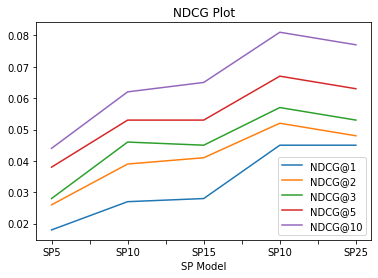

In [106]:
import matplotlib.pyplot as plt

# gca stands for 'get current axis'
ax = plt.gca()
ax.set_title("NDCG Plot")
metrices_df.plot(kind='line',x='SP Model',y=['NDCG@1','NDCG@2','NDCG@3','NDCG@5','NDCG@10'],ax=ax)
plt.show()

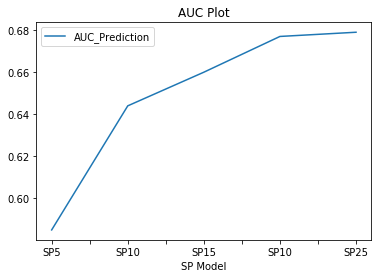

In [109]:
ax = plt.gca()
ax.set_title("AUC Plot")
metrices_df.plot(kind='line',x='SP Model',y=['AUC_Prediction'],ax=ax)
plt.show()

## Recommendations

In [10]:
item_lookup = twitter_count_df[['Domain']].drop_duplicates() # Only get unique item/description pairs
item_lookup['Domain'] = item_lookup.Domain.astype(str)

In [11]:
#using sp model 20

username_arr = np.array(list(np.sort(sdf_drop_20.index.unique())))
domain_arr = np.array(list(np.sort(sdf_drop_20.columns.unique())))

NameError: name 'sdf_drop_20' is not defined

In [29]:
username_arr

array(['001Bbot', '0060U', '007AliSohrab', ..., 'zypisfy', 'zyujinn',
       'zywiecPolska'], dtype='<U15')

In [30]:
domain_arr

array(['100percentfedup.com', '1011now.com', '10best.com', ...,
       'zerohedge.com', 'zimbio.com', 'zinnedproject.org'], dtype='<U30')

In [31]:
def get_domains_viewed(customer_id, dataset,customers_list, domain_list,item_lookup):
    
    '''
    dataset: either train or test dataset 
    '''
    
    cust_ind = np.where(customers_list == customer_id)[0][0] # Returns the index row of our customer id
    
    domain_ind = dataset[cust_ind,:].nonzero()[1]# Get column indices of viewed domains
    print(domain_ind)
    domain_codes = domain_list[domain_ind] # Get the index for viewed domains
    return item_lookup.loc[item_lookup.Domain.isin(domain_codes)]

In [33]:
get_domains_viewed('1Progressivism', train_sp20, username_arr, domain_arr, item_lookup)

[ 627  670  990 1067 1121 1387 1391 1405 1509 1544 1554 1585]


,Domain
612,theguardian.com
682,usatoday.com
718,huffpost.com
1031,nytimes.com
5964,nbcnews.com
7179,washingtonpost.com
8315,vanityfair.com
11719,thedailybeast.com
15542,truthout.org
32118,theconversation.com


#### Two ways used to generate the recpmmendations

### Method 1: Directly using the implicit library function model.recommend

In [34]:
def generate_recommendations(user_id,model,domain_user_data,spd,num_items):
    '''
    model: ALS model
    spd: sparse dataframe
    
    '''
    
    cust_ind = np.where((np.array(list(np.sort(spd.index.unique())))) == user_id)[0][0] # Returns the index row of our customer id
    
    #Recommendations
    recommended = model.recommend(cust_ind, domain_user_data.T)
    
    domains = []
    scores = []

    # Get domains names from ids
    for item in recommended:
        idx, score = item

        domains.append(spd.columns[idx])
        scores.append(score)

    # Create a dataframe of artist names and scores
    recommendations = pd.DataFrame({'Domain': domains, 'score': scores})
    return recommendations


In [36]:
generate_recommendations("1Progressivism",model_sp20,domain_user_data_sp20,sdf_drop_20,10)


,Domain,score
0,nytimes.com,1.048380
1,yahoo.com,1.041746
2,thedailybeast.com,1.031049
3,theguardian.com,1.001260
4,apnews.com,0.948218
5,dailykos.com,0.934918
6,huffpost.com,0.925615
7,newyorker.com,0.895206
8,nbcnews.com,0.894041
9,vanityfair.com,0.877412


### Method 2: User defined way to calculate --> To get the actual score we take the dot product between the trained user vector and the transpose of the item vectors.

In [37]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, num_items = 10):
 
    
    '''
    This function will return the top recommended items to our users 
    
    parameters:
    
    customer_id - Input the customer's id number that you want to get recommendations for
    
    mf_train - The training matrix you used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_vecs - the item vectors from your fitted matrix factorization
    
    customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    item_list - an array of the domains that make up the columns of your ratings matrix
                    (in order of matrix)
    
    
    num_items - The number of domains you want to recommend in order of best recommendations. Default is 10. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that domains not used yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already used zero

    
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    
  
    recommend_vector = pref_vec*rec_vector_scaled 
    

    # domains already used have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the domains into order 
    #print(product_idx)
    
    # of best recommendations
    rec_list = [] # start empty list to store items
    similairty_scores = []
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code]) 
        similairty_scores.append(recommend_vector[index])
        
    codes = [item[0] for item in rec_list]
    final_frame = pd.DataFrame({'Domain': codes,'Score':similairty_scores}) # Create a dataframe
    print("Recommended domains for the user")
    return final_frame # Switch order of columns around

In [38]:
rec_items("1Progressivism", train_sp20, user_vecs_sp20, item_vecs_sp20, username_arr, domain_arr,
                       num_items = 10)

Recommended domains for the user


,Domain,Score
0,yahoo.com,0.996141
1,apnews.com,0.941738
2,dailykos.com,0.934002
3,newyorker.com,0.910903
4,vox.com,0.898845
5,msnbc.com,0.867575
6,motherjones.com,0.861506
7,msn.com,0.850413
8,politicususa.com,0.838574
9,thehill.com,0.825085


### Trying some other implicit libarary functions

### model.similar_items()

In [51]:
#get the index of domain
np.where(domain_arr == "foxnews.com")

(array([519]),)

In [55]:
similar = model_sp20.similar_items(519, 10)

# Print the names of our most similar domains
for item in similar:
    idx, score = item
    print(sdf_drop_20.columns[idx],score)
    

foxnews.com 1.0000001
fox13memphis.com 0.6824376
wcax.com 0.66804504
nbcbayarea.com 0.6031035
heritage.org 0.5695114
nowtheendbegins.com 0.55519575
fox61.com 0.54916537
kfor.com 0.5316525
artsy.net 0.50988466
wsoctv.com 0.5067214


### model.similar_users()

In [56]:
#get the index of user
np.where(username_arr == "1Progressivism")

(array([201]),)

In [58]:
similar_user = model_sp20.similar_users(201, 10)

# Print the names of our most similar domains
for item in similar_user:
    idx, score = item
    print(sdf_drop_20.index[idx],score)

1Progressivism 0.9999999
Rteefact 0.82365507
MaraAlmudena2 0.8223703
bettyp711 0.76631665
llomenzo 0.75601846
MikeReeseM 0.754416
orangeorchards 0.75046104
dianexav1 0.7478097
buffaloon 0.7469688
Djama18291981 0.7452957


### model.recommend_all()

In [34]:
#this function helps in getting top N recommendations for every user

recommendations_complete = model_sp20.recommend_all(domain_user_data_sp20,10)
    
domains = []

# Get domain names from ids
for item in recommendations_complete:
    idx = item
    domains.append(sdf_drop_20.columns[idx])

# Create a dataframe of domains names
# print(pd.DataFrame({'Domain': domains}))
all_users_recommendations_df = pd.DataFrame(sdf_drop_20.index,columns=['Username'])
all_users_recommendations_df[['rec1', 'rec2', 'rec3', 'rec4', 'rec5', 'rec6', 'rec7', 'rec8', 'rec9', 'rec10']] = domains

In [35]:
all_users_recommendations_df

,Username,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10
0,001Bbot,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
1,0060U,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
2,007AliSohrab,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
3,007Dufour007,instagram.com,lnk.to,iheart.com,bbc.co.uk,latimes.com,msnbc.com,independent.co.uk,wordpress.com,metro.co.uk,nypost.com
4,007Eureka,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
...,...,...,...,...,...,...,...,...,...,...,...
39095,zxq9_notits,breitbart.com,washingtonpost.com,wordpress.com,spotify.com,yahoo.com,nytimes.com,apple.com,instagram.com,google.com,tumblr.com
39096,zygmuntmichnie1,bloomberg.com,youtube.com,cnbc.com,ft.com,wordpress.com,abc.net.au,timesofisrael.com,dailystar.co.uk,theguardian.com,smh.com.au
39097,zypisfy,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
39098,zyujinn,apple.com,instagram.com,facebook.com,latimes.com,lnk.to,youtube.com,reuters.com,cbsnews.com,oann.com,newsweek.com


In [36]:
#save and load all users recommendations dataframe
save_obj(all_users_recommendations_df,"/research/cbuntain/projects/recsys.trajectories/datafiles/Twitter dataframes/all_users_recommendations_df")


### Generate Recommendations for new users

In [225]:
def recalculate_user(domain_list,user_ratings,model,item_user_matrix):
    '''adds new user and its liked items to sparse matrix and returns recalculated recommendations
    
    domain_list: array of domains that new user wants to rate
    user_ratings: array to ratings to respective domains
    model: ALS model
    item_user_matrix: A sparse matrix of shape (number_users, number_items). 
    
    '''

    alpha = 15
    m =item_user_matrix
    n_users, n_movies = m.shape

    ratings = [element * alpha for element in user_ratings]
    #print(ratings)
    
    indx =(domain_arr[:, None] == domain_list).argmax(axis=0)
    #print(idx)

    m.data = np.hstack((m.data, ratings))
    m.indices = np.hstack((m.indices, indx))
    m.indptr = np.hstack((m.indptr, len(m.data)))
    m._shape = (n_users+1, n_movies)

    # recommend N items to new user
    
    recommended =  model.recommend(n_users, m, recalculate_user=True)
    domains = []
    scores = []
    for item in recommended:
        idx, score = item

        domains.append(sdf_drop_20.columns[idx])
        scores.append(score)

    # Create a dataframe of artist names and scores
    recommendations = pd.DataFrame({'Domain': domains, 'score': scores})
    return recommendations

In [226]:
domain_list=["foxnews.com","cnn.com"]
user_ratings=[20,3]
model = model_sp20
item_user_matrix=domain_user_data_sp20
recalculate_user(domain_list,user_ratings,model,item_user_matrix)

,Domain,score
0,youtube.com,0.819453
1,breitbart.com,0.746757
2,dailymail.co.uk,0.456596
3,nypost.com,0.452793
4,nbcnews.com,0.384058
5,washingtontimes.com,0.359593
6,washingtonexaminer.com,0.309266
7,dailycaller.com,0.307947
8,usatoday.com,0.304253
9,townhall.com,0.286832
